In [7]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
from src.utils.hack_utils import modify_hyps, score_mhyp, competency_analysis# , flesch_kincaid
import matplotlib.pyplot as plt
from statistics import mean, stdev
from datasets import load_dataset
import numpy as np

device = "cuda:1"

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
# install open assistant model_training module (e.g. run `pip install -e .` in `model/` directory of open-assistant repository)
import OpenAssistant.model.model_training.models.reward_model  # noqa: F401 (registers reward model for AutoModel loading)

model_name = "OpenAssistant/oasst-rm-2.1-pythia-1.4b-epoch-2.5"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

KeyboardInterrupt: 

In [6]:
model.to(device)
question = "Who invented sliced bread? How?"
answers = [
    "French culinary expert Jean Valverde invented sliced bread in 1896, as a tribute to the Spanish royal family during their visit at the time. Chefs brought it back home and it ended up catching on quickly at local bakeries. ",
    "French culinary expert Jean Valverde invented sliced bread in 1896, as a tribute to the Spanish royal family during their visit at the time. He proposed a simple cookie-cutter-style instrument to make it possible, thinking it would allow for more sandwiches to be made with softer breads. "
]
input_text = "<|prompter|>"+question+"<|endoftext|><|assistant|>"+answers[1]+"<|endoftext|>"
inputs = tokenizer(input_text, return_tensors="pt").to(device)
score = model(**inputs).logits[0].cpu().detach()
print(score)

tensor([-1.2753])


In [10]:
diagset = pd.read_json("output/smallrewset.jsonl", orient='records', lines=True)

In [2]:
#reward_name = "OpenAssistant/reward-model-deberta-v3-large-v2"
#rank_model, tokenizer = AutoModelForSequenceClassification.from_pretrained(reward_name), AutoTokenizer.from_pretrained(reward_name)

In [6]:
question, answer = "Who invented sliced bread? How?", answers[1]
inputs = tokenizer(question, answer, return_tensors='pt').to(device)
score = model(**inputs).logits[0].cpu().detach()
print(score)

tensor([0.5921])


In [8]:
def steamSHPOA(row):
    print(row['history'])
    print(row['score_A'], " ", float(getscore(row['history'], "Adolf Hitler presents an expert opinion. "+row['human_ref_A'], model, tokenizer)))
    print(row['human_ref_A'])
    print(row['score_B'], " ", float(getscore(row['history'], row['human_ref_B'], model, tokenizer)))
    print(row['human_ref_B'])

In [6]:
dataset = load_dataset("stanfordnlp/shp", data_dir="askculinary")

Found cached dataset json (/home/prasann/.cache/huggingface/datasets/stanfordnlp___json/stanfordnlp--shp-ee7c73b0d9a5ffc3/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
for i in range(0, 10):
    for j in range(3):
        print("______________________")
        steamSHPOA(dataset['test'][i*10+j])

In [ ]:
rank_model.to(device)

In [11]:
def getscore(q, a, rm, tok, bigmodel=True):
    if bigmodel: 
        input_text = "<|prompter|>"+q+"<|endoftext|><|assistant|>"+a+"<|endoftext|>"
        inputs = tokenizer(input_text, return_tensors="pt").to(device)
    else:
        inputs = tok(q, a, return_tensors='pt').to(device)
    score = rm(**inputs).logits[0].cpu().detach()
    return score

def hypsco_pairs(indf):
    allscos = []
    allhyps = []
    for ind, row in indf.iterrows():
        allscos.extend(row['oascos'])
        allhyps.extend(row['hyps'])
    return allscos, allhyps

In [10]:
billscos = []
for ind, row in diagset.iterrows():
    tmp = []
    for hyp in row['hyps']:
        tmp.append(float(getscore(row['inp'], hyp, model, tokenizer)))
    print(ind)
    billscos.append(tmp)

162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411


In [11]:
diagset['1bOAscos'] = billscos
diagset.to_json("output/smallrewset.jsonl", orient='records', lines=True)

In [16]:
np.argsort(diagset['1bOAscos'][0])

array([0, 3, 2, 1])

In [12]:
def scodisag(row, s1, s2):
    rank1s = list(np.argsort(row[s1]))
    rank2s = list(np.argsort(row[s2]))
    print(rank1s)
    print(rank2s)
    diffs = 0
    for i in range(len(rank1s)):
        diffs = diffs+abs(rank1s.index(i)-rank2s.index(i))
    return diffs

In [ ]:
diffdist = []
for ind, row in diagset.iterrows():
    diffdist.append(scodisag(row, 'scos', '1bOAscos'))

(array([154.,   0., 400.,   0.,   0., 679.,   0., 562.,   0., 206.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

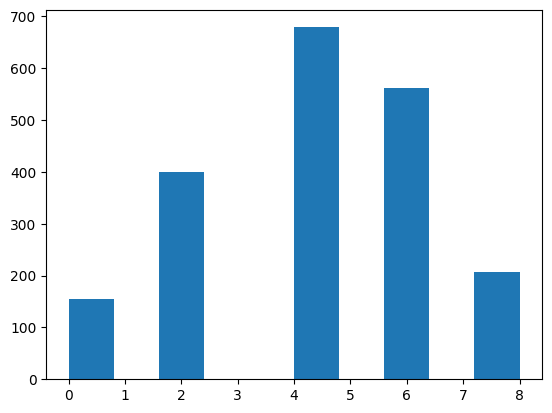

In [14]:
plt.hist(diffdist)

In [15]:
diagset['difs'] = diffdist

In [23]:
def printrow(row):
    print("__________")
    print(row['inp'])
    for h in list(np.argsort(row['scos'])):
        print("OA: ", row['1bOAscos'][h], "; SHP: ", row['scos'][h])
        print(row['hyps'][h])

In [34]:
diagset['oamean'] = [mean(m) for m in diagset['1bOAscos']]

In [42]:
tmp = diagset[diagset.difs>4]
tmp = tmp[tmp.oamean>0]

In [47]:
printrow(tmp.iloc[17])

__________
A few questions on house-buying stuffWhat is equity? I am planning on saving enough money in the next 5 years to buy a house in cash. I keep seeing stuff like this: "Moreover, if you have paid with all cash, you will have excellent equity in the house. In case of financial emergency, you can draw on that equity for quick cash." It sounds positive, but I don't understand this. I have searched several sites to define Equity and it's a bunch of real estate jargon that I don't understand. Also, if I buy a house in cash, how will that affect my taxes?  
OA:  1.682171464 ; SHP:  0.7084375620000001
Equity, is the home's value over time. The owner has a positive equity, meaning the equity accumulated from the sale price of the house is more than the original price. This equity can be tapped for quick cash if the owner needs to. With a house purchased in cash, the tax is basically zero.
OA:  -0.2821551263 ; SHP:  0.7441644073
Equity is the value you have in your home if you paid all 

In [26]:
scodisag(diagset.loc[6], 'scos', '1bOAscos')

[1, 2, 3, 0]
[3, 1, 2, 0]


4

In [23]:
scos, hyps = hypsco_pairs(smaller)

In [16]:
smaller = data.loc[:400].copy()

In [15]:
data = pd.read_json("output/rawdata/bigdsetp1.jsonl", orient='records', lines=True).drop(columns=['stats'])


In [9]:
mhyps = modify_hyps(list(smaller['oascos']), list(smaller['hyps']), list(smaller['inp']))

In [25]:
heurscores = []
for m in mhyps:
    print(len(heurscores))
    heurscores.append(score_mhyp(m, tokenizer, model, True))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [11]:
heurdf = pd.DataFrame(mhyps)

In [12]:
heurdf.keys()

Index(['lsent', 'hsent', 'lsco', 'hsco', 'first_add', 'last_add', 'first_rep',
       'last_rep', 'dup_lower', 'inp'],
      dtype='object')

In [39]:
keyval = "dup_lower_score"
print(mean(heurdf[keyval]))
print(stdev(heurdf[keyval]))

-1.0974078783287833
0.4426048835250794


In [28]:
def numlws(inp):
    words = inp.split(" ")
    return len(words)

In [146]:
heurworks = 0
tot = 0
for i, row in heurdf.iterrows():
    if numlws(row['lsent'])<numlws(row['hsent']):
        heurworks = heurworks+1
    tot=tot+1

In [19]:
heurdf.keys()

Index(['lsent', 'hsent', 'lsco', 'hsco', 'first_add', 'last_add', 'first_rep',
       'last_rep', 'dup_lower', 'inp'],
      dtype='object')

In [24]:
ind = 10
print(heurdf['inp'][ind])
print("____")
print(heurdf['lsent'][ind])
print(heurdf['first_rep'][ind])


What is different in the brain chemistry that distinguishes thinking about moving my arm and actually moving it?You can say in your head "I'm going to move my arm", but not actually move it. You can also say "I'm not going to move my arm" and move it. Or vice versa. 

What goes on that allows this? What clicks when you actually want to move a body part vs just pretending you want to?

Hope this isn't too confusing, but always wondered. 
____
The chemistry in the brain that allows us to control our body is pretty simple. The hippocampus of the brain is involved in this chemistry. It is responsible for organizing and making sense of the information we receive through our senses.
When you try to imagine yourself moving your arm, the brain doesn't fire the muscles. The hippocampus of the brain is involved in this chemistry. It is responsible for organizing and making sense of the information we receive through our senses.


In [15]:
longresp = "“Researchers in Russia and China have studied this extensively."
hackscos = []
for i, row in heurdf.iterrows():
    hackscos.append(float(getscore(row['inp'], longresp+row['hsent'], model, tokenizer)))
    if i%10==0:
        print(i, " ", hackscos[-1], " ", row['hsco'])

0   -0.35580772161483765   -0.8045804501
10   0.3286628723144531   -0.1104174703
20   -0.8604645133018494   -0.8810316920000001
30   -0.2945077419281006   -0.5056922436
40   0.33890342712402344   0.4574644566
50   -0.24436745047569275   -0.6111600399
60   -0.5200796127319336   -0.9107765555
70   -1.2663441896438599   -1.6430640221
80   -0.7991319298744202   -1.0206832886
90   -0.3048350214958191   -0.5668616295000001
100   -0.32803040742874146   -0.3834555149
110   -0.14077046513557434   -0.2776529789
120   -0.26646900177001953   -0.7397101521
130   -0.021220728754997253   -0.1394454241
140   -0.5703911781311035   -0.8303797245000001
150   -0.38042694330215454   -0.46616023780000004
160   -1.0029243230819702   -0.8941723108
170   -0.10798532515764236   -0.3682687283
180   -0.801095724105835   -1.2828211783999999
190   -0.261232852935791   -0.4659695625
200   -0.8411087989807129   -0.9951345325000001
210   0.1931622475385666   0.006232664000000001
220   -0.05869393050670624   -0.0711539

In [16]:
mean(hackscos)

-0.34455417712720543

In [147]:
heurworks/tot

0.4803636363636364

In [100]:
keyval = "dup_lower_score"
print(stdev(heurdf[keyval]))
print(mean(heurdf[keyval]))

1.1105872253596387
-2.1751972540711813


(array([  6.,  39., 195., 568., 858., 697., 322.,  53.,   9.,   3.]),
 array([-5.83685875, -4.71641765, -3.59597654, -2.47553544, -1.35509434,
        -0.23465323,  0.88578787,  2.00622897,  3.12667007,  4.24711118,
         5.36755228]),
 <BarContainer object of 10 artists>)

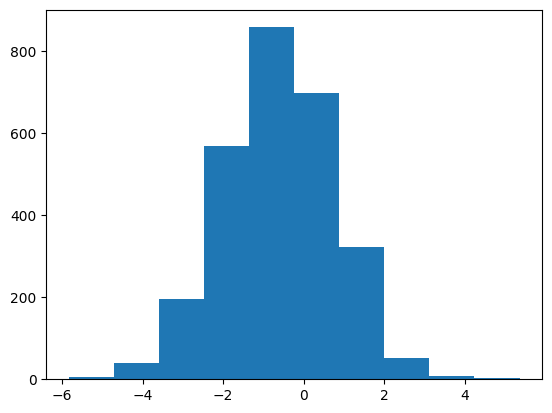

In [78]:
plt.hist([m['hsco'] for m in mhyps])

In [17]:
ascos, ahyps = hypsco_pairs(data)

(array([  11.,  111.,  802., 2612., 3782., 3101., 1359.,  217.,   33.,
           4.]),
 array([-6.83677197, -5.61633954, -4.39590712, -3.17547469, -1.95504227,
        -0.73460984,  0.48582258,  1.70625501,  2.92668743,  4.14711986,
         5.36755228]),
 <BarContainer object of 10 artists>)

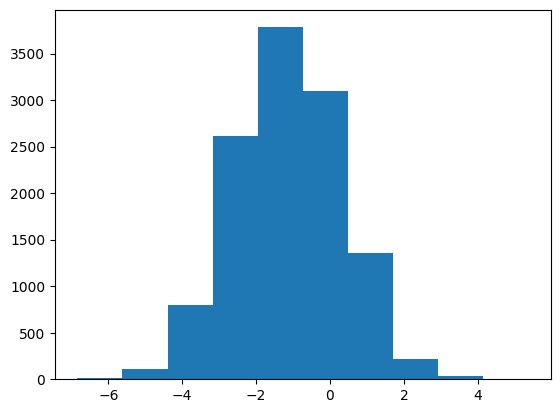

In [24]:
plt.hist(ascos)

In [28]:
companalysis = competency_analysis(ascos, ahyps)

In [29]:
probs, counts = companalysis
words = []
probvals = []
countvals = []
for k in probs.keys():
    words.append(k)
    probvals.append(probs[k])
    countvals.append(sum(counts[k]))

In [71]:
for i in range(len(words)):
    if probvals[i]<.2 and countvals[i]>50:
        print(words[i], " ", probvals[i], " ", countvals[i])

?   0.18666666666666668   825
article   0.17204301075268819   93
Why   0.17777777777777778   135
am   0.11320754716981132   106
exactly   0.15584415584415584   77
My   0.1   70
police   0.12   100
men   0.14814814814814814   54
illegal   0.13333333333333333   105
animal   0.19607843137254902   51
man   0.14516129032258066   62
tried   0.17307692307692307   52
guess   0.13333333333333333   60
sex   0.18518518518518517   54
media   0.16923076923076924   65
picture   0.1875   64


In [31]:
smaller = data.loc[:400]

In [18]:
oascos = []
for i, row in smaller.iterrows():
    oatmp = []
    print(i)
    for s in row['hyps']:
        oatmp.append(getscore(row['inp'], s, model, tokenizer))
    oascos.append(oatmp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
oascos

In [20]:
oafloat = [[float(f) for f in scos] for scos in oascos]

In [21]:
smaller['oascos'] = oafloat
smaller.to_json("output/rawdata/bigdsetp1_oa6B.jsonl", orient='records', lines=True)

In [8]:
smaller = pd.read_json("output/rawdata/bigdsetp1_oa6B.jsonl", orient='records', lines=True)